In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from offroad.utils import load_state
import json
import ipywidgets as widgets
from car_dynamics.models_torch.dataset import clean_random_data
from car_dynamics.analysis import pos2vel_savgol, calc_delta
from ipywidgets import interact
%matplotlib inline
%load_ext autoreload
%autoreload 2

PROJ_DIR = '/Users/wenlixiao/Dropbox/School/Graduate/LeCAR/safe-learning-control/playground/offroad/data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
## load data
imu_all_dir = 'data-imu-calibrate-2024-02-15/subset-imu-data.csv'
imu_rpy_dir = 'data-imu-calibrate-2024-02-15/subset-imu-rpy.csv'

mocap_dir = 'data-20240216-135002'

In [42]:
with open(os.path.join(PROJ_DIR, mocap_dir, 'header.json')) as f:
    header_info = json.load(f)
t_list, p_dict, yaw_dict, action_list, controller_info = load_state(os.path.join(PROJ_DIR, mocap_dir), [0,411], orientation_provider="ORIENTATION_PROVIDOER")
date_list = p_dict['date']
obs_np = p_dict['obs']
imu_rpy = pd.read_csv(os.path.join(PROJ_DIR, imu_rpy_dir))
imu_all = pd.read_csv(os.path.join(PROJ_DIR, imu_all_dir))
imu_time = imu_rpy['.header.stamp.secs'].to_numpy() + imu_rpy['.header.stamp.nsecs'].to_numpy() / (10**9)
imu_yaw = imu_rpy['.vector.z'].to_numpy()
imu_ang_vel = imu_all['.angular_velocity.z'].to_numpy()
imu_acc_x = imu_all['.linear_acceleration.x'].to_numpy()
imu_acc_y = imu_all['.linear_acceleration.y'].to_numpy()
start_time = min(imu_time[0], t_list[0])
t_list -= start_time
imu_time -= start_time

## Calibrate Yaw Angle

We compare yaw angle by three different sources:

- 1. by vicon
- 2. by IMU heading (calculated by EKF)
- 3. by IMU angular velocity

In [43]:
def plot(a=0,b=3000, shift=0.74):
    plt.plot(t_list[a:b], obs_np[a:b, 2], label='vicon yaw')
    shift_imu = imu_yaw + shift
    shift_imu = np.arctan2(np.sin(shift_imu), np.cos(shift_imu))
    plt.plot(imu_time[a:b], shift_imu[a:b], label='imu heading', alpha=0.5)
    t_fit = [shift_imu[a]]
    for step in range(a+1, b):
        new_heading = t_fit[-1] + (imu_time[step]-imu_time[step-1]) * imu_ang_vel[step-1]
        new_heading = np.arctan2(np.sin(new_heading), np.cos(new_heading))
        t_fit.append(new_heading)
    plt.plot(imu_time[a:b], t_fit, label='imu heading by ang_vel', alpha=0.5)
    plt.legend()
    plt.xlabel("time (s)")
    plt.ylabel("angle (rad)")
interact(plot, 
         a = (0, obs_np.shape[0], 1),
         b = (0, obs_np.shape[0], 1),
         shift=(-np.pi, 2*np.pi, 0.001)
        )

interactive(children=(IntSlider(value=0, description='a', max=4110), IntSlider(value=3000, description='b', ma…

<function __main__.plot(a=0, b=3000, shift=0.74)>

In [44]:
delta_t = np.expand_dims(t_list[1:] - t_list[:-1], 1)
vel_vec = obs_np[1:, :2] - obs_np[:-1, :2] / delta_t

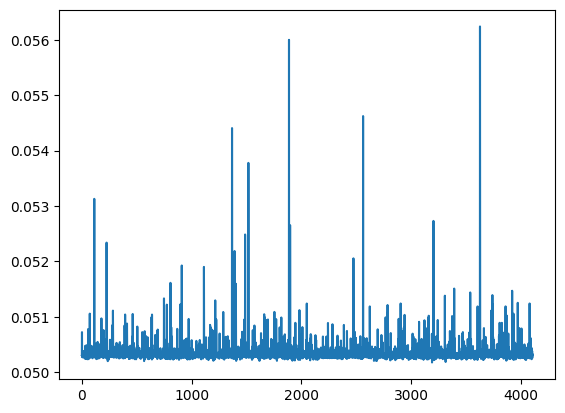

In [45]:
plt.plot(delta_t)

Text(0, 0.5, 'vel (m/s)')

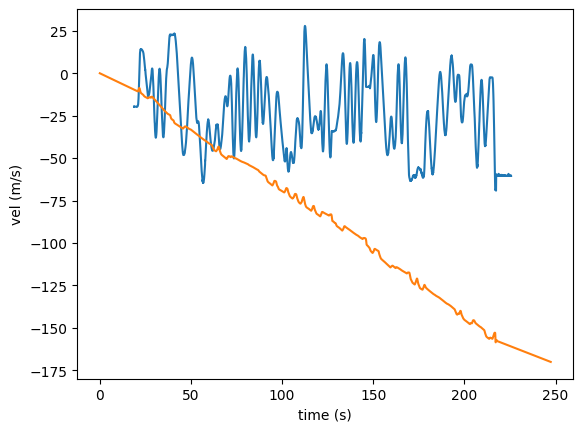

In [46]:
v_start = 0
plt.plot(t_list[:-1], vel_vec[:, 0], label='vel x by vicon')
vel_x = [v_start]
for step in range(1, len(imu_time)):
    vel_x.append(vel_x[-1] + (imu_acc_x[step-1]) * (imu_time[step] - imu_time[step-1]))
plt.plot(imu_time, vel_x, label='vel x by linear acc')
plt.xlabel("time (s)")
plt.ylabel("vel (m/s)")

(0.0, 250.0)

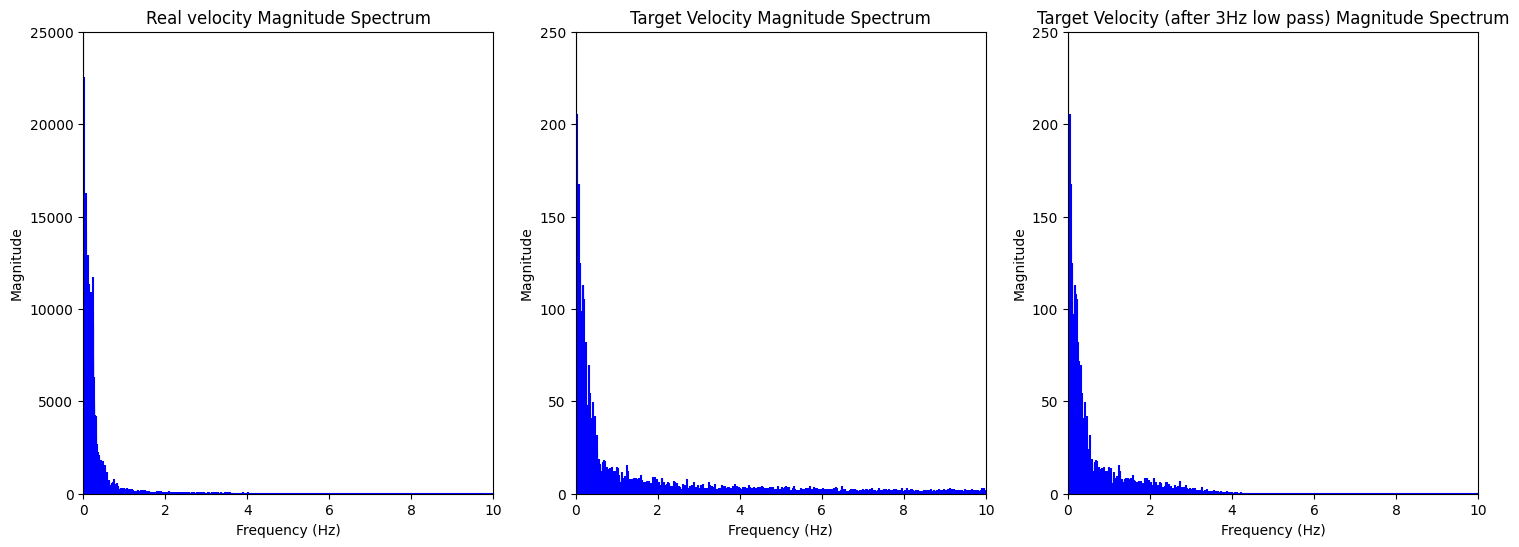

In [68]:
vel = np.sqrt(vel_vec[:,0]**2 + vel_vec[:,1]**2)
fft_result = np.fft.fft(vel)
n = len(fft_result)
dt=0.05
frequency = np.fft.fftfreq(n, d=dt)
fs = 1 / dt  #
magnitude = np.abs(fft_result)

# Plotting
plt.figure(figsize=(18, 6))

# Plot magnitude spectrum
plt.subplot(1, 3, 1)
plt.stem(frequency, magnitude, 'b', markerfmt=" ", basefmt="-b")
plt.title('Real velocity Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 10)  # Limit to positive frequencies
plt.ylim(0, 25000)

action_smooth = action_list[:, 0] + 0.
fft_result = np.fft.fft(action_smooth)
n = len(fft_result)
frequency = np.fft.fftfreq(n, d=dt)
magnitude = np.abs(fft_result)

plt.subplot(1, 3, 2)
plt.stem(frequency, magnitude, 'b', markerfmt=" ", basefmt="-b")
plt.title('Target Velocity Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 10)  # Limit to positive frequencies
plt.ylim(0, 250)



fft_result = np.fft.fft(action_smooth)
n = len(fft_result)
frequency = np.fft.fftfreq(n, d=dt)
magnitude = np.abs(fft_result)

plt.subplot(1, 3, 3)
plt.stem(frequency, magnitude, 'b', markerfmt=" ", basefmt="-b")
plt.title('Target Velocity (after 3Hz low pass) Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 10)  # Limit to positive frequencies
plt.ylim(0, 250)

In [51]:
LF = .16
LR = .15
delta, beta = calc_delta(vel_vec, obs_np[:-1, 2], LF, LR)

(0.0, 1000.0)

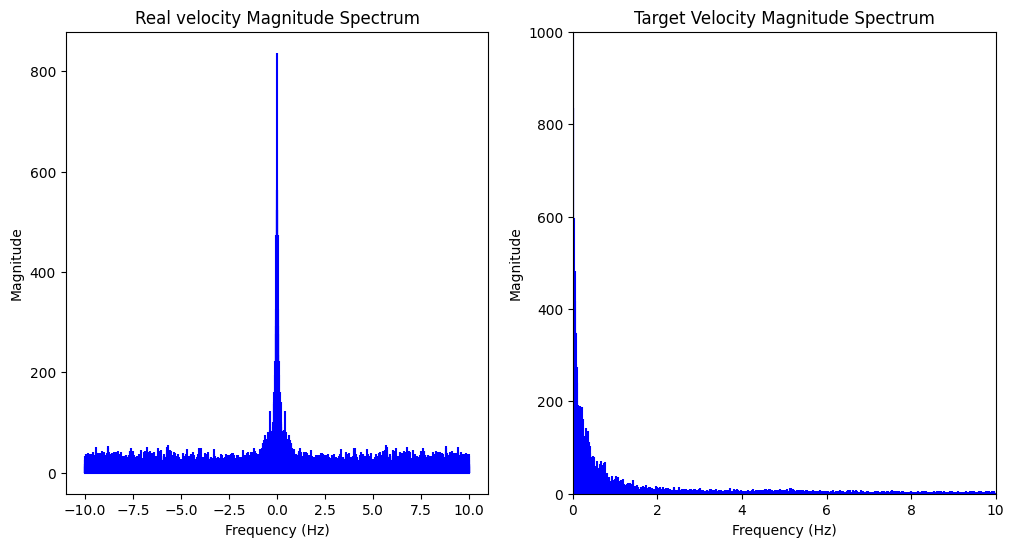

In [56]:
fft_result = np.fft.fft(delta)
n = len(fft_result)
dt=0.05
frequency = np.fft.fftfreq(n, d=dt)
fs = 1 / dt  #
magnitude = np.abs(fft_result)

# Plotting
plt.figure(figsize=(12, 6))

# Plot magnitude spectrum
plt.subplot(1, 2, 1)
plt.stem(frequency, magnitude, 'b', markerfmt=" ", basefmt="-b")
plt.title('Real velocity Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
# plt.xlim(0, 5)  # Limit to positive frequencies
# plt.ylim(0, 25000)

action_smooth = action_list[:, 1] + 0.
for i in range(1, len(action_smooth)):
    action_smooth[i] = 0. * action_smooth[i-1] + 1. * action_list[i, 1]
fft_result = np.fft.fft(action_smooth)
n = len(fft_result)
frequency = np.fft.fftfreq(n, d=dt)
magnitude = np.abs(fft_result)

plt.subplot(1, 2, 2)
plt.stem(frequency, magnitude, 'b', markerfmt=" ", basefmt="-b")
plt.title('Target Velocity Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.xlim(0, 10)  # Limit to positive frequencies
plt.ylim(0, 1000)
